## Introduction
This experiment developed a system that is designed to facilitate communication between people who have vocal-auditory disability. The experiment has machine learning techniques to perform the due process of recognition of hand gestures of the Colombian sign language, recognizing the numbers from 0 to 5 and the vowels. 

This experiment works through 4 stages: taking photographs, pre-processing the photo, extracting the characteristics of the photo and finally performs the classification process for the identification of the gesture being carried out. 
The image is captured by any camera that has a good quality shot. Then move on to the next stage of pre-processing, where you want to clean the techniques to remove the shadow, the background and leave the image clean to perform the process of segmentation where the process of eliminating the noises that this pose takes place. 

At the stage of extraction of characteristics, it extracts the characteristics of the image that give us the mathematical methods like: Moments of Hu, ellipticals of Fourier, histograms oriented to gradients (HOG) and geometric characteristics. 
Finally, using the vector support machine classifier (SVM) you get the value of the sign, if it is a number or a vowel.

## Exploratory Analysis
To begin this exploratory analysis, first import libraries and define functions perform pre-processing and extracting features ` Cv2` (OpenCV), ` Sklearn`, `scipy`, `skimage`. 
Use the `pyefd` library to get the Fourier ellipticals.
For the classification processes the library of `sklearn` was used.


In [1]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/kaggle"
# !kaggle datasets download -d evernext10/hand-gesture-of-the-colombian-sign-language
# !unzip '/content/kaggle/hand-gesture-of-the-colombian-sign-language.zip' -d '/content/kaggle/dataset'
# !rm -rf /content/kaggle/dataset/men/A

In [5]:
# %pip install pyefd


<module 'cv2' from 'C:\\Users\\aatta\\AppData\\Roaming\\Python\\Python39\\site-packages\\cv2\\__init__.py'>

In [2]:
import os
import numpy as np
# import cv2
import cv2 as cv2
# import cv2.cv2 as cv2

from scipy import ndimage as ndi
import imageio
from os import walk
from pyefd import elliptic_fourier_descriptors
from skimage import feature
import pandas as pd
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split,GridSearchCV  
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns;
import collections
import joblib
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from scipy.stats import skew
from skimage import segmentation
from skimage.filters import sobel
sns.set()
np.random.seed(42)



There is 0 csv file in the current version of the dataset:


The next hidden code cells define functions for plotting data. Click on the "Code" button in the published kernel to reveal the hidden code.

In [15]:
# !rm -rf /content/kaggle/dataset/dataset
def plt_t(title, img, cmap=None):
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.show()

In [4]:
# %%capture
# Pre-processing of the images is done
base = './'
def segm_1(img_rgb):
  img_ycrcb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2YCR_CB)  
  ycrcbmin = np.array((0, 133, 77))
  ycrcbmax = np.array((255, 173, 127))
  skin_ycrcb = cv2.inRange(img_ycrcb, ycrcbmin, ycrcbmax)
  kernel = np.ones((5, 5), np.uint8)
  img_erode = cv2.erode(skin_ycrcb, kernel, iterations=2)  
  holesimg = ndi.binary_fill_holes(img_erode).astype(np.int) 
  return holesimg

def segm_2(img_rgb):
  lab = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2LAB)
  # bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
  _, _, r = cv2.split(lab)
  r = cv2.normalize(r, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
  elevation_map = sobel(r)
  markers = np.zeros_like(r)
  markers[r < 30] = 1
  markers[r > 150] = 2
  segmentation_coins = cv2.watershed(img_rgb, markers)
  return segmentation_coins


def segm_3(img_rgb):
  blur = cv2.GaussianBlur(img_rgb, (3, 3), 0)

  # Convert image to LAB color space
  lab = cv2.cvtColor(blur, cv2.COLOR_BGR2LAB)
  # bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
  # lab = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2LAB)
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  lab[:, :, 0] = clahe.apply(lab[:, :, 0])

  # Convert image back to BGR color space
  bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
  # it was 50, 190
  canny = cv2.Canny(bgr, 10, 170)
  # opening = cv2.morphologyEx(canny, cv2.MORPH_OPEN, (3, 3))
  return canny

def is_lightened(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    _, _, v = cv2.split(hsv)
    quantiles = np.quantile(v, [0.5])
    # print(quantiles)
    return quantiles[0] > 230

def segm_4(img):
    # Convert image to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    # Apply CLAHE to enhance contrast in LAB lightness channel
    clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(18,18))
    lab[:, :, 0] = clahe.apply(lab[:, :, 0])

    # Convert image back to BGR color space
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    # Display original and preprocessed images side by side
    # apply cannny edge detection
    edges = cv2.Canny(bgr, 100, 200)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 8))
    opening = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=1)
    from skimage import morphology
    holesimg = ndi.binary_fill_holes(opening).astype(np.int8)
    bin = holesimg>0.5
    a = morphology.remove_small_objects(bin, 1000)
    return (a*255).astype(np.uint8)

def segm_5(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mk = img_hsv > np.array([0, 0, 230])
    mk = mk.astype(np.float32)
    mask = (mk *0.5 + 0.5)
    masked = (mask* img_hsv)
    img_partly_darken = cv2.cvtColor(masked, cv2.COLOR_HSV2RGB)
    green_mask = (img_partly_darken[:, :, 0] > img_partly_darken[:, :, 1]).astype(np.float32)
    kernel = np.ones((5, 5), np.uint8)
    img_erode = cv2.erode(green_mask, kernel, iterations=2)  
    holesimg = ndi.binary_fill_holes(img_erode).astype(np.int) 
    return holesimg
  
def segm_6(img):
#     blur the img then turn it into gray scale
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    return gray

def segm_7(img):
    # Convert BGR to HSV color space
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    # Split HSV image into separate channels
    _, _, B_channel = cv2.split(hsv_img)
    _, trr2 = cv2.threshold(
        B_channel, 1, 1.0, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    trr2 = ndi.binary_fill_holes(trr2).astype(np.int8)
    masked_data = cv2.bitwise_and(img, img, mask=trr2)
    return cv2.cvtColor(masked_data, cv2.COLOR_BGR2GRAY)

def make_to_left(img):
  a = img.sum(axis=0)
  a = a / a.max()
  if(a[:int(len(a)//8)].sum() < a[int(len(a)*7//8):].sum()):
    # flip the image
    return cv2.flip(img, 1)
  return img

def preprocess(direc):
  try:
    img_rgb = cv2.imread(direc)
    img_rgb = cv2.resize(img_rgb, (461, 260))
  except:
    print("cant read image")
    return None
  # if(is_lightened(img_rgb)):
  #   holesimg = segm_5(img_rgb)
  # else:
  #   holesimg = segm_1(img_rgb)
  holesimg = segm_7(img_rgb)
  # holesimg = segm_4(img_rgb)
  # holesimg = segm_6(img_rgb)
  holesimg = make_to_left(holesimg)
  return holesimg


def ImageSegmentation():
    path_IS = r"./Image-Segmentation2"
    if not os.path.exists(path_IS):
        os.makedirs(path_IS)
    lstFiles = []  # nombre de imagenes
    path = r"./dataset"

    for (path, _, archivos) in walk(path):
        # print(path)
        for arch in archivos:
            (nomArch, ext) = os.path.splitext(arch)
            if (ext == ".JPG"):
                # label = path.split("\\")[-1]
                # print(label)
                lstFiles.append(nomArch + ext)
                direc = path + "/" + nomArch + ext
                name =  nomArch + ext
                # print(path + "/" + nomArch + ext)
                
                holesimg = preprocess(direc)
                if(holesimg is None):
                  continue
                # holesimage = segm_3(holesimg)
                imageio.imwrite(os.path.join(path_IS, name), holesimg)
                
ImageSegmentation()
# plt.show()
# img = cv2.imread(r"dataset\men\1\1_men (1).JPG")
# img_p = preprocess(r"dataset\men\1\1_men (2).JPG")
# plt_t('',img_p,cmap='gray')

cant read image
cant read image
cant read image
cant read image
cant read image
cant read image


In [65]:
# %%capture
# Pre-processing of the images is done
base = './'
def segm_1(img_rgb):
  img_ycrcb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2YCR_CB)  
  ycrcbmin = np.array((0, 133, 77))
  ycrcbmax = np.array((255, 173, 127))
  skin_ycrcb = cv2.inRange(img_ycrcb, ycrcbmin, ycrcbmax)
  kernel = np.ones((5, 5), np.uint8)
  img_erode = cv2.erode(skin_ycrcb, kernel, iterations=2)  
  holesimg = ndi.binary_fill_holes(img_erode).astype(np.int) 
  return holesimg

def segm_2(img_rgb):
  lab = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2LAB)
  # bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
  _, _, r = cv2.split(lab)
  r = cv2.normalize(r, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
  elevation_map = sobel(r)
  markers = np.zeros_like(r)
  markers[r < 30] = 1
  markers[r > 150] = 2
  segmentation_coins = cv2.watershed(img_rgb, markers)
  return segmentation_coins


def segm_3(img_rgb):
  blur = cv2.GaussianBlur(img_rgb, (3, 3), 0)

  # Convert image to LAB color space
  lab = cv2.cvtColor(blur, cv2.COLOR_BGR2LAB)
  # bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
  # lab = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2LAB)
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  lab[:, :, 0] = clahe.apply(lab[:, :, 0])

  # Convert image back to BGR color space
  bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
  # it was 50, 190
  canny = cv2.Canny(bgr, 10, 170)
  # opening = cv2.morphologyEx(canny, cv2.MORPH_OPEN, (3, 3))
  return canny

def is_lightened(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    _, _, v = cv2.split(hsv)
    quantiles = np.quantile(v, [0.5])
    # print(quantiles)
    return quantiles[0] > 230

def segm_4(img):
    # Convert image to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    # Apply CLAHE to enhance contrast in LAB lightness channel
    clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(18,18))
    lab[:, :, 0] = clahe.apply(lab[:, :, 0])

    # Convert image back to BGR color space
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    # Display original and preprocessed images side by side
    # apply cannny edge detection
    edges = cv2.Canny(bgr, 100, 200)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 8))
    opening = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=1)
    from skimage import morphology
    holesimg = ndi.binary_fill_holes(opening).astype(np.int8)
    bin = holesimg>0.5
    a = morphology.remove_small_objects(bin, 1000)
    return (a*255).astype(np.uint8)

def segm_5(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mk = img_hsv > np.array([0, 0, 230])
    mk = mk.astype(np.float32)
    mask = (mk *0.5 + 0.5)
    masked = (mask* img_hsv)
    img_partly_darken = cv2.cvtColor(masked, cv2.COLOR_HSV2RGB)
    green_mask = (img_partly_darken[:, :, 0] > img_partly_darken[:, :, 1]).astype(np.float32)
    kernel = np.ones((5, 5), np.uint8)
    img_erode = cv2.erode(green_mask, kernel, iterations=2)  
    holesimg = ndi.binary_fill_holes(img_erode).astype(np.int) 
    return holesimg
  
def segm_6(img):
#     blur the img then turn it into gray scale
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    return gray


def make_to_left(img):
  a = img.sum(axis=0)
  a = a / a.max()
  if(a[:int(len(a)//8)].sum() < a[int(len(a)*7//8):].sum()):
    # flip the image
    return cv2.flip(img, 1)
  return img

def preprocess(direc):
  try:
    img_rgb = cv2.imread(direc)
    img_rgb = cv2.resize(img_rgb, (461, 260))
  except:
    print("cant read image")
    return None
  # if(is_lightened(img_rgb)):
  #   holesimg = segm_5(img_rgb)
  # else:
  #   holesimg = segm_1(img_rgb)
  holesimg = segm_3(img_rgb)
  # holesimg = segm_4(img_rgb)
  # holesimg = segm_6(img_rgb)
  holesimg = make_to_left(holesimg)
  return holesimg


def ImageSegmentation():
    path_IS = r"./Image-Segmentation-sara"
    if not os.path.exists(path_IS):
        os.makedirs(path_IS)
    lstFiles = []  # nombre de imagenes
    path = r"./sara_dataset"

    for (path, _, archivos) in walk(path):
        # print(path)
        for arch in archivos:
            (nomArch, ext) = os.path.splitext(arch)
            if (ext == ".JPG"):
                label = path.split("\\")[-1]
                # print(label)
                lstFiles.append(nomArch + ext)
                direc = path + "/" + nomArch + ext
                name =  label + "_" + nomArch + ext
                # print(path + "/" + nomArch + ext)
                
                holesimg = preprocess(direc)
                if(holesimg is None):
                  continue
                # holesimage = segm_3(holesimg)
                imageio.imwrite(os.path.join(path_IS, name), holesimg)
                
ImageSegmentation()
# plt.show()
# img = cv2.imread(r"dataset\men\1\1_men (1).JPG")
# img_p = preprocess(r"dataset\men\1\1_men (2).JPG")
# plt_t('',img_p,cmap='gray')

CountFlips

482.98791872597474
14.27742953320964
500
393


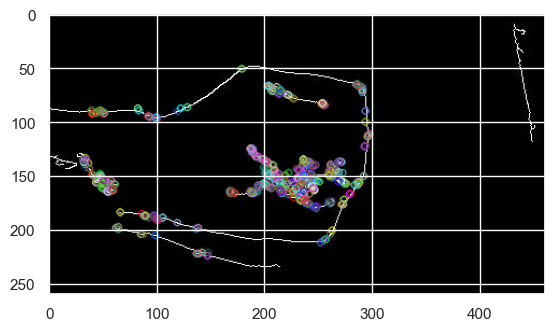

In [31]:
# extratct sift key points and descriptors and draw them
def extract_sift(img):
  # sift = cv2.xfeatures2d.SIFT_create()
  orb = cv2.ORB_create()

  kp, des = orb.detectAndCompute(img, None)
  return kp, des

def draw_sift(img, kp):
    img = cv2.drawKeypoints(img, kp, None)
    return img

img = cv2.imread(r"Image-Segmentation2/0_men (3).JPG")
img = cv2.resize(img, (461, 260))
kp, des = extract_sift(img)
img = draw_sift(img, kp)
plt.imshow(img)



base = "./"
def CountFlips():
    print("CountFlips\n")
    path_EF = base + r"Feature-Extraction"
    if not os.path.exists(path_EF):
        os.makedirs(path_EF)

    file = open(base + r"Feature-Extraction/CountFlips.txt", "w")
    lstFiles = []  # nombre de imagenes
    path = r"./Image-Segmentation2"
    all_lings = []
    for (path, _, archivos) in walk(path):
        for arch in archivos:
            (nomArch, ext) = os.path.splitext(arch)
            if (ext == ".JPG"):
                direc = path + "/" + nomArch + ext
                name = nomArch + ext
                # print(nomArch + ext)
                img_binary = cv2.imread(direc)
                kp, des = extract_sift(img_binary)
                all_lings.append(len(kp))

    all_lings = np.array(all_lings)
    print(all_lings.mean())
    print(all_lings.std())
    print(all_lings.max())
    print(all_lings.min())
CountFlips()

In [12]:
base = "./"
def VHist():
    print("VHIST\n")
    path_EF = base + r"Feature-Extraction"
    if not os.path.exists(path_EF):
        os.makedirs(path_EF)

    file = open(base + r"Feature-Extraction/VHIST.txt", "w")
    path = r"./Image-Segmentation2"
    for (path, _, archivos) in walk(path):
        for arch in archivos:
            (nomArch, ext) = os.path.splitext(arch)
            if (ext == ".JPG"):
                direc = path + "/" + nomArch + ext
                name = nomArch + ext
                # print(nomArch + ext)
                img_binary = cv2.imread(direc)
                img_binary = cv2.cvtColor(img_binary, cv2.COLOR_BGR2GRAY)
                # get vertical histogram
                ss = img_binary.sum(axis=1)
                print(ss[0])
                file.write(name)    
                for item in ss:
                    file.write(",%.4f" % item)
                file.write("," + name[0] + "\n")
    file.close()
VHist()



VHIST

257
0
74
0
290
0
2744
829
0
292
0
92
0
773
653
398
50
0
331
0
0
0
73
0
328
343
0
0
0
0
0
296
58
0
260
0
0
0
17
42
0
310
268
0
0
0
270
0
0
0
0
0
0
0
326
0
0
295
592
0
0
1103
0
0
291
0
0
0
270
0
0
257
0
0
0
0
0
0
0
0
0
549
0
0
0
0
0
0
0
0
0
564
3202
1033
0
0
0
0
0
0
92
572
1487
899
0
0
0
0
0
359
321
0
0
665
0
0
0
260
0
529
0
0
0
345
0
55
54
0
0
0
580
0
0
0
0
0
0
0
0
0
363
0
305
0
355
959
349
0
287
0
0
0
0
0
0
0
0
0
0
0
0
0
0
345
289
622
379
0
0
0
0
0
0
0
0
0
0
0
0
0
0
514
0
0
291
266
0
0
0
0
299
1198
0
0
0
16
0
45
0
344
0
0
0
0
1195
0
0
0
0
0
809
0
0
0
269
15
0
0
0
0
626
0
0
897
619
496
912
0
0
271
381
0
559
802
1687
301
0
279
52
577
430
2190
161
35
517
0
660
0
0
0
0
0
0
44
0
0
314
647
0
383
0
0
479
0
0
1329
292
0
0
47
134
0
151
0
0
0
163
0
0
147
0
0
273
0
0
574
0
309
0
34
62
309
0
0
0
0
111
0
0
262
48
0
0
370
81
272
0
0
344
0
325
0
306
0
275
0
0
0
269
132
0
0
24
0
0
0
0
0
379
0
0
0
0
0
0
60
0
0
303
0
0
258
0
0
0
858
0
0
299
0
0
551
0
0
0
600
0
0
0
0
60
272
0
0
0
0
0
0
311
0
0
356

In [19]:
# The Fourier elliptical features are extracted from each of the images and we proceed to save them in a. txt file.
base = "./"
def CountFlips():
    print("CountFlips\n")
    path_EF = base + r"Feature-Extraction"
    if not os.path.exists(path_EF):
        os.makedirs(path_EF)

    file = open(base + r"Feature-Extraction/CountFlips.txt", "w")
    lstFiles = []  # nombre de imagenes
    path = r"./Image-Segmentation"
    for (path, _, archivos) in walk(path):
        for arch in archivos:
            (nomArch, ext) = os.path.splitext(arch)
            if (ext == ".JPG"):
                lstFiles.append(nomArch + ext)
                direc = path + "/" + nomArch + ext
                name = nomArch + ext
                print(nomArch + ext)
                img_binary = cv2.imread(direc)

                img_binary = cv2.cvtColor(img_binary, cv2.COLOR_BGR2GRAY)
                # count the number of black/white flips on the column of the image 
                counts = []
                for col in range(0,img_binary.shape[1],10):
                    first = img_binary[0, col]
                    count =0
                    for row in range(img_binary.shape[0]):
                        if img_binary[row, col] != first:
                            count += 1
                            first = img_binary[row, col]
                        
                    counts.append(count)
                file.write(name)    
                for item in range(len(counts)):
                    file.write(",%.4f" % counts[item])
                file.write("," + name[0] + "\n")

    file.close()
CountFlips()

CountFlips

0_men (1).JPG
0_men (10).JPG
0_men (100).JPG
0_men (101).JPG
0_men (102).JPG
0_men (103).JPG
0_men (104).JPG
0_men (105).JPG
0_men (106).JPG
0_men (107).JPG
0_men (108).JPG
0_men (109).JPG
0_men (11).JPG
0_men (110).JPG
0_men (111).JPG
0_men (112).JPG
0_men (113).JPG
0_men (114).JPG
0_men (115).JPG
0_men (116).JPG
0_men (117).JPG
0_men (118).JPG
0_men (119).JPG
0_men (12).JPG
0_men (120).JPG
0_men (121).JPG
0_men (122).JPG
0_men (123).JPG
0_men (124).JPG
0_men (125).JPG
0_men (126).JPG
0_men (127).JPG
0_men (128).JPG
0_men (129).JPG
0_men (13).JPG
0_men (130).JPG
0_men (131).JPG
0_men (132).JPG
0_men (133).JPG
0_men (134).JPG
0_men (135).JPG
0_men (136).JPG
0_men (137).JPG
0_men (138).JPG
0_men (139).JPG
0_men (14).JPG
0_men (140).JPG
0_men (141).JPG
0_men (142).JPG
0_men (143).JPG
0_men (144).JPG
0_men (145).JPG
0_men (146).JPG
0_men (147).JPG
0_men (148).JPG
0_men (149).JPG
0_men (15).JPG
0_men (150).JPG
0_men (151).JPG
0_men (152).JPG
0_men (153).JPG
0_men (154).JPG
0_me

In [55]:
# The Fourier elliptical features are extracted from each of the images and we proceed to save them in a. txt file.
base = "./"
def EF_oper(img_rgb):
    img_binary = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    _, img_binary = cv2.threshold(img_binary, 127, 255, 0)
    contours, _ = cv2.findContours(img_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    maxcontour = max(contours, key=cv2.contourArea)
    # cv2.drawContours(img_rgb,[maxcontour],0,(255,9,9))
    # plt_t('cont',img_rgb)
    coeffs = []
    # Find the coefficients of all contours
    coeffs.append(elliptic_fourier_descriptors(np.squeeze(maxcontour), order=13))
    # print("coeff",coeffs)
    coeffs2 = []
    for row in coeffs:
        for elem in row:
            coeffs2.append(elem)
    coeffs = []
    for row in coeffs2:
        for elem in row:
            coeffs.append(elem)
    return np.array(coeffs)


def EllipticFourier():
    print("EF\n")
    path_EF = base + r"Feature-Extraction"
    if not os.path.exists(path_EF):
        os.makedirs(path_EF)

    file = open(base + r"Feature-Extraction/Elliptic-Fourier.txt", "w")
    # file = open(r"C:\Users\Ever\Desktop\Elliptic-Fourier.txt", "w")
    lstFiles = []  # nombre de imagenes
    path = r"./Image-Segmentation"
    for (path, _, archivos) in walk(path):
        for arch in archivos:
            (nomArch, ext) = os.path.splitext(arch)
            if (ext == ".JPG"):
                lstFiles.append(nomArch + ext)
                direc = path + "/" + nomArch + ext
                name = nomArch + ext
                print(nomArch + ext)
                img_binary = cv2.imread(direc)
                coeffs = EF_oper(img_binary)
                file.write(name)
                for item in range(len(coeffs)):
                    file.write(",%.4f" % coeffs[item])
                file.write("," + name[0] + "\n")

    file.close()
EllipticFourier()
# img_binary = cv2.imread(r'Image-Segmentation2\0_men (4).JPG')
# coeffs = EF_oper(img_binary)

EF



In [28]:
import cv2
from sklearn.cluster import KMeans
import pickle
from scipy.spatial.distance import cdist
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def extract_sift_features(img):
    # image_descriptors = []
    # sift = cv2.xfeatures2d.SIFT_create()
    orb = cv2.ORB_create()
    _, descriptors = orb.detectAndCompute(img, None)
    # image_descriptors.append(descriptor)
    return descriptors

def kmean_bow(all_descriptors, num_cluster):
    bow_dict = []
    kmeans = KMeans(n_clusters = num_cluster)
    kmeans.fit(all_descriptors)

    bow_dict = kmeans.cluster_centers_

    if not os.path.isfile('./Feature-Extraction/bow_dictionary.pkl'):
        pickle.dump(bow_dict, open('./Feature-Extraction/bow_dictionary.pkl', 'wb'))
    return bow_dict

def create_feature_bow(image_descriptors, BoW, num_cluster):

    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_cluster)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], BoW)

            argmin = np.argmin(distance, axis = 1)

            for j in argmin:
                features[j] += 1
        X_features.append(features)

    return X_features


# The Histogram of Oriented Gradients features are extracted from each of the images and we proceed to save them in a. txt file
def SIFT():
    print("SIFT\n")
    file  = open(r"./Feature-Extraction/SIFT.txt", "w")
    lstFiles = []  # nombre de imagenes
    path = r"./Image-Segmentation2"
    all_descriptors = []
    image_desctiptors = []
    all_names = []
    for (path, _, archivos) in walk(path):
        for arch in archivos:
            (nomArch, ext) = os.path.splitext(arch)
            if (ext == ".JPG"):
                lstFiles.append(nomArch + ext)
                direc = path + "/" + nomArch + ext
                name = nomArch + ext
                print(name)
                all_names.append(name)
                # print(nomArch + ext)
                img_binary = cv2.imread(direc)
                descriptors = extract_sift_features(img_binary)


                # Load SIFT descriptors
                # descriptors = np.load("descriptors.npy")

                # Normalize descriptors
                scaler = StandardScaler()
                descriptors_norm = scaler.fit_transform(descriptors)

                # Cluster descriptors using k-means
                kmeans = KMeans(n_clusters=100)
                kmeans.fit(descriptors_norm)

                # Compute visual word histograms for each image
                labels = kmeans.predict(scaler.transform(descriptors))

                # Compute histogram of visual words
                histogram, _ = np.histogram(labels, bins=range(100), density=True)


                # image_desctiptors.append(desc)
    #             kmeans = KMeans(n_clusters=50)
    #             kmeans.fit(desc)
    # #             create histogram
    #             histogram1 = np.zeros(100)
    #             for descriptor in desc:
    #                 index = kmeans.predict([descriptor.astype(np.double)])
    #                 histogram1[index] += 1
                file.write(name)
                for item in range(len(histogram)):
                    file.write(",%.3f" % histogram[item])
                file.write("," + name[0] + "\n")

    # all_descriptors = []
    # for descriptor in image_desctiptors:
    #     if descriptor is not None:
    #         for des in descriptor:
    #             all_descriptors.append(des)
                
                
    # num_cluster = 150
    # BoW = kmean_bow(all_descriptors, num_cluster)
    # X_features = create_feature_bow(image_desctiptors, BoW, num_cluster)
    # print(len(X_features))
    # print(X_features[0])
    
    # for i in range(len(all_names)):
    #     file.write(all_names[i])
    #     for item in range(len(X_features[i])):
    #         file.write(",%.3f" % X_features[i][item])
    #     file.write("," + all_names[i][0] + "\n")
    # file.close()
    
SIFT()



SIFT

0_men (1).JPG
0_men (10).JPG
0_men (100).JPG
0_men (101).JPG
0_men (102).JPG
0_men (103).JPG
0_men (104).JPG
0_men (105).JPG
0_men (106).JPG
0_men (107).JPG
0_men (108).JPG
0_men (109).JPG
0_men (11).JPG
0_men (110).JPG
0_men (111).JPG
0_men (112).JPG
0_men (113).JPG
0_men (114).JPG
0_men (115).JPG
0_men (116).JPG
0_men (117).JPG
0_men (118).JPG
0_men (119).JPG
0_men (12).JPG
0_men (120).JPG
0_men (121).JPG
0_men (122).JPG
0_men (123).JPG
0_men (124).JPG
0_men (125).JPG
0_men (126).JPG
0_men (127).JPG
0_men (128).JPG
0_men (129).JPG
0_men (13).JPG
0_men (130).JPG
0_men (131).JPG
0_men (132).JPG
0_men (133).JPG
0_men (134).JPG
0_men (135).JPG
0_men (136).JPG
0_men (137).JPG
0_men (138).JPG
0_men (139).JPG
0_men (14).JPG
0_men (140).JPG
0_men (141).JPG
0_men (142).JPG
0_men (143).JPG
0_men (144).JPG
0_men (145).JPG
0_men (146).JPG
0_men (147).JPG
0_men (148).JPG
0_men (149).JPG
0_men (15).JPG
0_men (150).JPG
0_men (151).JPG
0_men (152).JPG
0_men (153).JPG
0_men (154).JPG
0_men (155

In [32]:


def HOG_oper(img_binary):
    (H) = feature.hog(img_binary, orientations=9, pixels_per_cell=(16,16),
                                  cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1",channel_axis=-1) 
    pca = joblib.load(r"./Feature-Extraction/pca.pkl") #PCA(0.97).fit_transform(H.reshape(1, -1))
    components = pca.transform(H.reshape(1, -1))
    # joblib.dump(pca, r"./Feature-Extraction/pca.pkl")
    return components

def HOG_PCA():
    data_HOG = pd.read_csv(r'./Feature-Extraction/Histogram-of-Oriented-Gradients.txt', sep=',', header=None)
    file2 = open(r"./Feature-Extraction/Histogram-of-Oriented-Gradients-PCA.txt", "w")
    name_HOG = data_HOG.iloc[:, 0]
    value_HOG = data_HOG.iloc[:, 1:-1]
    tag_HOG = data_HOG.iloc[:, -1] # 0,1,2,3,4,5
    print("PCA")
    pca = PCA(0.97).fit(value_HOG)
    joblib.dump(pca, r"./Feature-Extraction/pca.pkl")
    
    components = pca.transform(value_HOG)
    print(components.shape)
    for row in range(len(components)):
        file2.write(name_HOG[row])
        for colm in range(len(components[row])):
            file2.write(",%.4f" %components[row][colm])
        file2.write(",%s" %tag_HOG[row] + "\n")
    file2.close()

# The Histogram of Oriented Gradients features are extracted from each of the images and we proceed to save them in a. txt file
# def HOG():
#     print("HOG\n")
#     file  = open(r"./Feature-Extraction/Histogram-of-Oriented-Gradients.txt", "w")
#     lstFiles = []  # nombre de imagenes
#     path = r"./Image-Segmentation2"
#     for (path, _, archivos) in walk(path):
#         for arch in archivos:
#             (nomArch, ext) = os.path.splitext(arch)
#             if (ext == ".JPG"):
#                 lstFiles.append(nomArch + ext)
#                 direc = path + "/" + nomArch + ext
#                 name = nomArch + ext
#                 # print(nomArch + ext)
#                 img_binary = cv2.imread(direc)
                
#                 (H) = feature.hog(img_binary, orientations=9, pixels_per_cell=(16,16),
#                                   cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1",channel_axis=-1)  # ,visualize=True
#                 # hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))     ,hogImage
#                 # hogImage = hogImage.astype("uint8")
                
#                 # plt.imshow("HOG Image", hogImage)
#                 file.write(name)
#                 for item in range(len(H)):
#                     file.write(",%.3f" % H[item])
#                 file.write("," + name[0] + "\n")
#     file.close()



def HOG():
    print("HOG\n")
    file  = open(r"./Feature-Extraction/Histogram-of-Oriented-Gradients.txt", "w")
    lstFiles = []  # nombre de imagenes
    path = r"./Image-Segmentation2"
    for (path, _, archivos) in walk(path):
        for arch in archivos:
            (nomArch, ext) = os.path.splitext(arch)
            if (ext == ".JPG"):
                lstFiles.append(nomArch + ext)
                direc = path + "/" + nomArch + ext
                name = nomArch + ext
                # print(nomArch + ext)
                img_binary = cv2.imread(direc)

                image = cv2.imread("Image-Segmentation2/" + arch)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = cv2.resize(image, (461, 260))
                
                (H, hogImage) = feature.hog(image, orientations=9,  pixels_per_cell=(32, 32), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", visualize=True, feature_vector=True)


                file.write(name)
                for item in range(len(H)):
                    file.write(",%.3f" % H[item])
                file.write("," + name[0] + "\n")
    file.close()

    
HOG()
HOG_PCA()

HOG

PCA
(3642, 497)


In [35]:
# The Hu Moments features are extracted from each of the images and we proceed to save them in a. txt file
# %pip install tqdm
from tqdm import tqdm

def HU_oper(img_binary):
    # https://www.pyimagesearch.com/2014/10/27/opencv-shape-descriptor-hu-moments-example/
    img_binary = cv2.cvtColor(img_binary, cv2.COLOR_BGR2GRAY)
    HU = cv2.HuMoments(cv2.moments(img_binary)).flatten()
    return HU

def HU():
    print("HU\n")

    file = open("./Feature-Extraction/Hu-Moments.txt", "w")

    lstFiles = []  # nombre de imagenes
    path = r"./Image-Segmentation2"
    for (path, _, archivos) in tqdm(walk(path)):
        for arch in archivos:
            (nomArch, ext) = os.path.splitext(arch)
            if (ext == ".JPG"):
                lstFiles.append(nomArch + ext)
                direc = path + "/" + nomArch + ext
                name = nomArch + ext
                #print(nomArch + ext)
                img_binary = cv2.imread(direc)
                
                HU = HU_oper(img_binary)
                file.write(name)
                for item in range(len(HU)):
                    # print(HU[item])
                    num = str(HU[item])
                    file.write(",%s" % num[0:25])
                    # print(num[0:22])
                file.write("," + name[0] + "\n")
    file.close()
    
    file = open(r"./Feature-Extraction/Hu-Moments-Nmz.txt", "w")

    data = pd.read_csv(r'./Feature-Extraction/Hu-Moments.txt', sep=',', header=None)

    name = data.iloc[:, 0]
    value = data.iloc[:, 1:-1]
    tag = data.iloc[:, -1]

    # print(value)
    normalizedata = normalize(value, axis=0, norm='max')
    # print(normalizedata)


    for row in range(len(normalizedata)):
        file.write(name[row])
        for colm in range(len(normalizedata[row])):
            # print(HU[item])
            num = str(normalizedata[row][colm])
            file.write(",%s" % num[0:25])
            # print(num[0:22])
        file.write("," + str(tag[row]) + "\n")
    file.close()

# HU()

In [54]:
def featureNormalize(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    normalized_X = (X - mu) / sigma
    
    return (normalized_X, mu, sigma)

def GM_oper(img_binary):
    img_binary = cv2.cvtColor(img_binary, cv2.COLOR_BGR2GRAY)

    ret, img_binary = cv2.threshold(img_binary, 127, 255, 0)
    contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    cnt = max(contours, key=cv2.contourArea)
    # reshape contour to 2d array
    # cnt = cnt.reshape(cnt.shape[0], cnt.shape[2])
    print(cnt.shape)
    # apply PCA to contour and keep first 25 components
    # pca = PCA(n_components=2)
    # cnt_pca = pca.fit_transform(cnt).flatten()
    # print(cnt_pca.shape)
    # return cnt_pca
    # print(cnt.shape)
    # # Area
    # area = cv2.contourArea(cnt)
    # # Perimetro
    # perimeter = cv2.arcLength(cnt, True)

    # # Relación de aspecto
    # x, y, w, h = cv2.boundingRect(cnt)
    # aspect_ratio = float(w) / h

    # # Grado
    # rect_area = w * h
    # extent = float(area) / rect_area

    # # ConvexHull
    # hull = cv2.convexHull(cnt)
    # hull_area = cv2.contourArea(hull)

    # # Solidez
    # solidity = float(area) / hull_area

    # # Diámetro equivalente
    # equi_diameter = np.sqrt(4 * area / np.pi)
    
    return cnt


# The Contour Features are extracted from each of the images and we proceed to save them in a. txt file
def GM():
    print("GM\n")

    file = open("./Feature-Extraction/Geometric.txt", "w")

    lstFiles = []  # nombre de imagenes
    path = r"./Image-Segmentation2"
    for (path, _, archivos) in walk(path):
        for arch in archivos:
            (nomArch, ext) = os.path.splitext(arch)
            if (ext == ".JPG"):
                lstFiles.append(nomArch + ext)
                direc = path + "/" + nomArch + ext
                name = nomArch + ext
                # print(nomArch + ext)
                img_binary = cv2.imread(direc)
                cnt_pca = GM_oper(img_binary)
                print(len(cnt_pca))
                file.write(name)
                for item in range(len(cnt_pca)):
                    # print(HU[item])
                    num = str(cnt_pca[item])
                    file.write(",%s" % num)
                    # print(num[0:22])
                # file.write("," + str(cnt_pca) + "\n")
                file.write("," + name[0] + "\n")
                # file.write(",%.4f" % area)
                # file.write(",%.4f" % perimeter)
                # file.write(",%.4f" % aspect_ratio)
                # file.write(",%.4f" % extent)
                # file.write(",%.4f" % hull_area)
                # file.write(",%.4f" % solidity)
                # file.write(",%.4f" % equi_diameter)
                # file.write("," + name[0] + "\n")
    file.close()
GM()

GM

(896, 1, 2)
896
(1664, 1, 2)
1664
(801, 1, 2)
801
(834, 1, 2)
834
(602, 1, 2)
602
(2802, 1, 2)
2802
(542, 1, 2)
542
(1005, 1, 2)
1005
(463, 1, 2)
463
(2593, 1, 2)
2593
(826, 1, 2)
826
(1160, 1, 2)
1160
(1157, 1, 2)
1157
(1982, 1, 2)
1982
(1703, 1, 2)
1703
(399, 1, 2)
399
(799, 1, 2)
799
(1469, 1, 2)
1469
(981, 1, 2)
981
(363, 1, 2)
363
(2192, 1, 2)
2192
(482, 1, 2)
482
(691, 1, 2)
691
(327, 1, 2)
327
(3270, 1, 2)
3270
(1190, 1, 2)
1190
(1707, 1, 2)
1707
(739, 1, 2)
739
(2310, 1, 2)
2310
(2505, 1, 2)
2505
(1800, 1, 2)
1800
(1706, 1, 2)
1706
(674, 1, 2)
674
(563, 1, 2)
563
(1299, 1, 2)
1299
(1061, 1, 2)
1061
(1056, 1, 2)
1056
(1302, 1, 2)
1302
(1512, 1, 2)
1512
(1744, 1, 2)
1744
(1452, 1, 2)
1452
(566, 1, 2)
566
(2294, 1, 2)
2294
(3045, 1, 2)
3045
(2211, 1, 2)
2211
(1498, 1, 2)
1498
(3503, 1, 2)
3503
(1623, 1, 2)
1623
(996, 1, 2)
996
(1068, 1, 2)
1068
(965, 1, 2)
965
(294, 1, 2)
294
(705, 1, 2)
705
(1411, 1, 2)
1411
(2280, 1, 2)
2280
(615, 1, 2)
615
(1294, 1, 2)
1294
(1048, 1, 2)
104

(1, 1199)
incorrect:  ./dataset/men\1/1_men (114).JPG


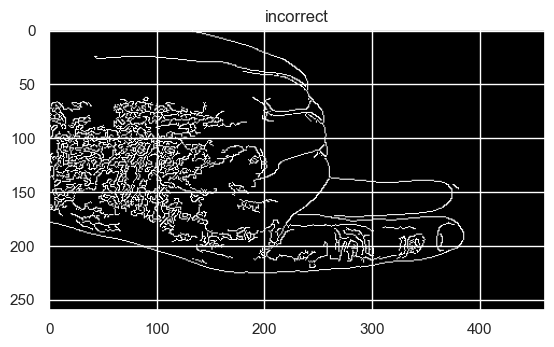

incorrect:  ./dataset/men\1/1_men (129).JPG


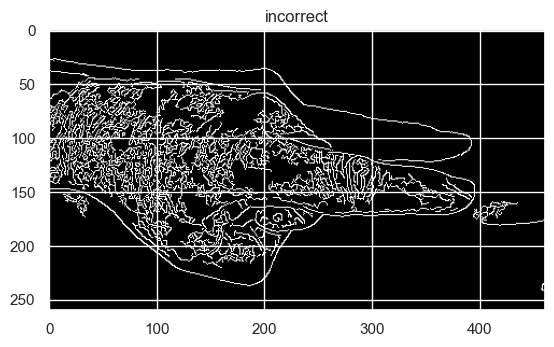

incorrect:  ./dataset/men\1/1_men (159).JPG


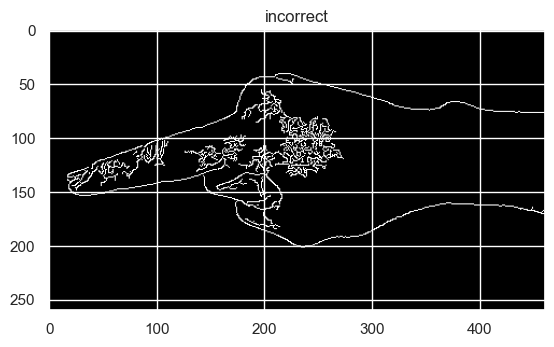

incorrect:  ./dataset/men\1/1_men (168).JPG


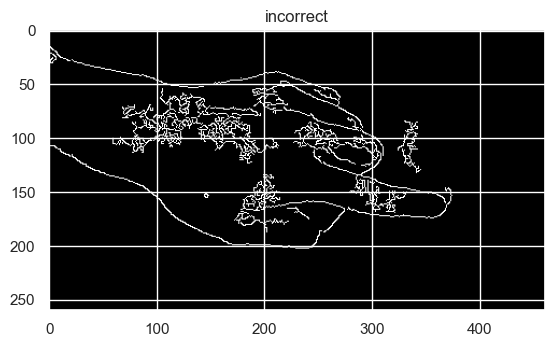

incorrect:  ./dataset/men\1/1_men (169).JPG


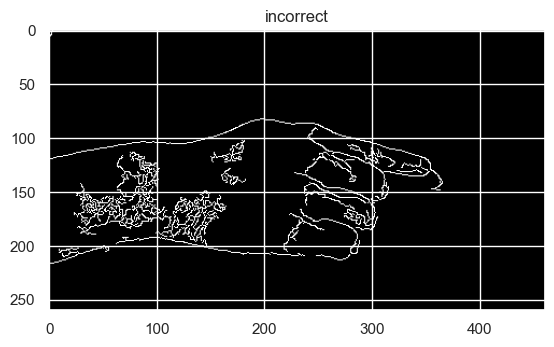

incorrect:  ./dataset/men\1/1_men (170).JPG


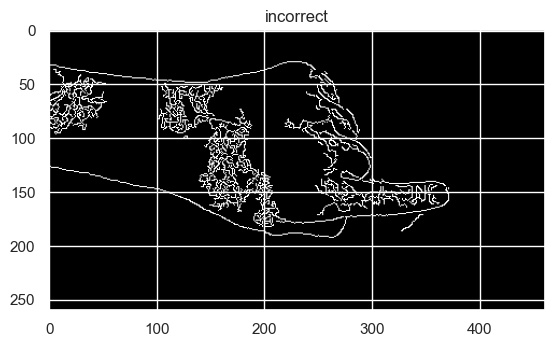

incorrect:  ./dataset/men\1/1_men (171).JPG


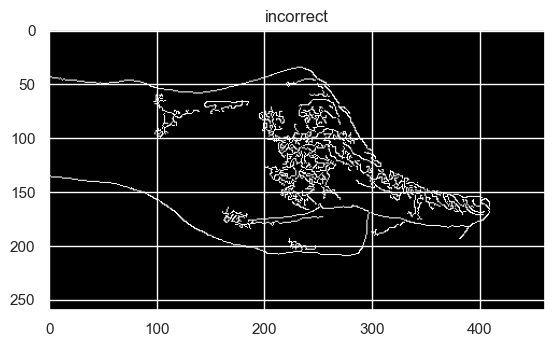

incorrect:  ./dataset/men\1/1_men (19).JPG


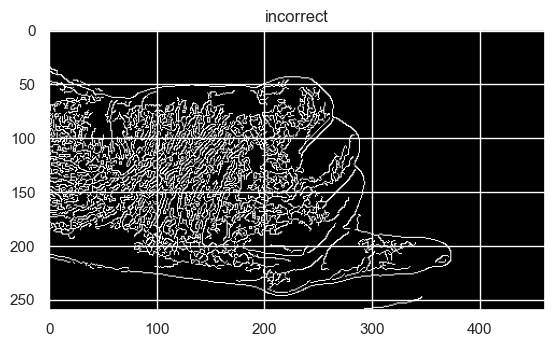

incorrect:  ./dataset/men\1/1_men (24).JPG


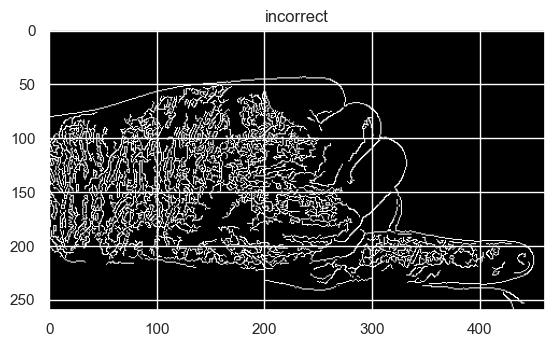

incorrect:  ./dataset/men\1/1_men (29).JPG


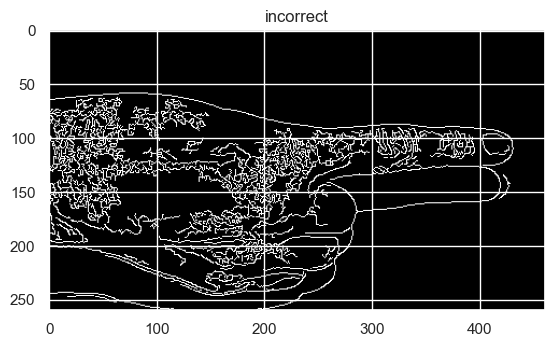

incorrect:  ./dataset/men\1/1_men (60).JPG


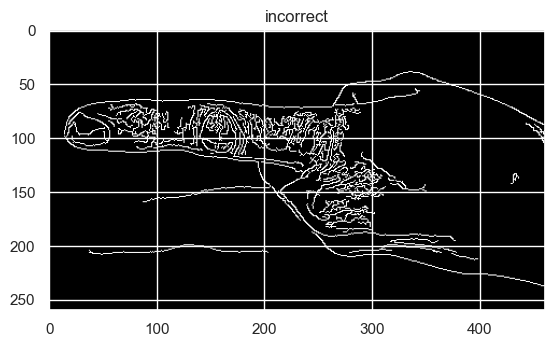

cant read image


error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [45]:
# # After obtaining the characteristics individually we proceed to make a unification 
def combineFeatures(preprocced_img):
    value_EF = EF_oper(preprocced_img)
    print("size EF: ",value_EF.shape)
    # value_HU = HU_oper(preprocced_img)
    # print("size HU: ",value_HU.shape)
    # normalized_HU = normalize(value_HU.reshape(-1,1),norm='max')
    # print("size HU: ",normalized_HU.shape)
    # value_GM = GM_oper(preprocced_img)
    # print("size GM: ",len(value_GM))
    VALUR_HOG = HOG_oper(preprocced_img)
    print("size HOG: ",VALUR_HOG.shape)

    # combine all values 
    value = np.concatenate((value_EF, VALUR_HOG), axis=None)
    return value

def CoF():
    print("Cof\n")

    file = open("./Feature-Extraction/CoF.txt", "w")
    file2 = open("./Feature-Extraction/HOG_EF.txt", "w")

    data_EF = pd.read_csv(r'./Feature-Extraction/Elliptic-Fourier.txt', sep=',', header=None)
    name_EF = data_EF.iloc[:, 0]
    value_EF = data_EF.iloc[:, 1:-1]
    tag_EF = data_EF.iloc[:, -1]
    print("EF: ",value_EF.shape)
    # -------------------------------- HM---------------------------------#
    data_HM = pd.read_csv(base + r'Feature-Extraction/Hu-Moments.txt', sep=',', header=None)
    value_HM = data_HM.iloc[:, 1:-1]
    normalizedata = normalize(value_HM, axis=0, norm='max')
    print("HM: ",normalizedata.shape)
    # -------------------------------- GM---------------------------------#
    data_GM = pd.read_csv(base + r'Feature-Extraction/Geometric.txt', sep=',', header=None)
    value_GM = data_GM.iloc[:, 1:-1]
    print("GM: ",value_GM.shape)
    # -------------------------------- HOG---------------------------------#
    data_HOG = pd.read_csv(base + r'Feature-Extraction/Histogram-of-Oriented-Gradients-PCA.txt', sep=',', header=None)
    value_HOG = data_HOG.iloc[:, 1:-1]
    print("HOG: ",value_HOG.shape)
    # -------------------------------- Save Cof ---------------------------------#
    
    for row in range(len(value_EF)):
        file.write(name_EF[row])
        file2.write(name_EF[row])
        for colm in range(value_EF.shape[1]):
            file.write(",%.4f" %value_EF.iloc[row,colm])
            file2.write(",%.4f" %value_EF.iloc[row,colm])
        for colm in range(len(normalizedata[row])):
            num = str(normalizedata[row][colm])
            file.write(",%s" % num[0:25])
        for colm in range(value_GM.shape[1]):
            file.write(",%.4f" %value_GM.iloc[row,colm])
        for colm in range(value_HOG.shape[1]):
            file.write(",%.4f" %value_HOG.iloc[row,colm])
            file2.write(",%.4f" %value_HOG.iloc[row,colm])
        file.write(",%s" %tag_EF[row] + "\n")
        file2.write(",%s" %tag_EF[row] + "\n")
        
    file.close()
    file2.close()

# CoF()
# EF:  (1827, 52)
# HM:  (1827, 7)
# GM:  (1827, 7)
# HOG:  (1827, 1250)

img = preprocess(r"dataset\men\0\0_men (7).JPG")
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
value = HOG_oper(img)
print(value.shape)

# load model and predict class
clf = joblib.load(r'Feature-Extraction\SVM\modelo_entrenado-Histogram-of-Oriented-Gradients-PCA-20%.pkl')
# clf.predict(value)

# loop over the testing images in us folder

path = r"./dataset/"
correct = 0
total = 0
for (path, _, archivos) in walk(path):
    for arch in archivos:
            (nomArch, ext) = os.path.splitext(arch)
            if (ext == ".JPG"):
                # load the image, convert it to grayscale, and resize it to be a fixed
                # 64x64 pixels, ignoring aspect ratio
                direc = path + "/" + nomArch + ext
                # print(direc)
                image = preprocess(direc)
                # plt_t("after preprocess",image, cmap='gray')
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
                value = HOG_oper(image)
                # value = combineFeatures(image)
                # load the image and classify it
                # print(path[-1])
                is_corr = 1 if (clf.predict(value)[0]) == path[-1] else 0
                if(is_corr == 0):
                    print("incorrect: ",direc)
                    plt_t("incorrect",image, cmap='gray')
                 
                correct += is_corr
                total+=1
                # show the prediction
print("correct: ",correct/total)

In [15]:
# PCA 

def featureNormalize(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    normalized_X = (X - mu) / sigma
    
    return (normalized_X, mu, sigma)



def PCAA():
    print("HU\n")

    file = open("./Feature-Extraction/pca.txt", "w")

    lstFiles = []  # nombre de imagenes
    path = r"./Image-Segmentation2"
    for (path, _, archivos) in walk(path):
        for arch in archivos:
            (nomArch, ext) = os.path.splitext(arch)
            if (ext == ".JPG"):
                lstFiles.append(nomArch + ext)
                direc = path + "/" + nomArch + ext
                name = nomArch + ext
                #print(nomArch + ext)
                img_binary = cv2.imread(direc)
                img_binary = cv2.cvtColor(img_binary, cv2.COLOR_BGR2GRAY)
                # make returned image as float32 datatype
                img_binary = np.float32(img_binary/255.0)
                
                X = normalize(img_binary, axis=0, norm='max')
                # take the most significant 25 vectors of the image and flatten it using PCA
                pca = PCA(n_components=25)
                X = pca.fit_transform(X)
                # print(X)
                file.write(name)
                for item in range(len(X)):
                    for item2 in range(len(X[item])):
                        file.write(",%s" % item2)
                        # print(HU[item])
                    # print(num[0:22])
    #             file.write(name)
    #             for item in range(len(HU)):
    #                 # print(HU[item])
    #                 num = str(HU[item])
    #                 file.write(",%s" % num[0:25])
    #                 # print(num[0:22])
                file.write("," + name[0] + "\n")
    file.close()


PCAA()


HU



We then proceed to create our classification methods

In [34]:
#As the first method of classification we use Support Vector Machine 


from sklearn.linear_model import SGDClassifier


base = "./"

def SVM(txt,test_percentage):
    pathsvm = base + "Feature-Extraction/SVM"
    
    if not os.path.exists(pathsvm):
        os.makedirs(pathsvm)
        
    data = pd.read_csv(base + '/Feature-Extraction/'+txt+'.txt',sep=',',header=None)
    
    # we shuffle it for better performance 
    # data=shuffle(data, random_state=42)
    
    s=data.shape
    # print(s)
    col=[]
    #data.columns = ["a", "b", "c", "etc."]
     
    for x in range(0, s[1]):
        if x==0:
            col.append("NAME")
        elif x ==s[1]-1:
            col.append("TAG")
        else:
            col.append("VALOR-"+str(x))
    
    #se asigna el vector con los nombres de las columnas creado previamente y se las asignamos a la tabla
    data.columns = col
    
    ##print(data.groupby(['TAG'])['TAG'].count())
    vals_to_replace = { '0':'0', '1':'1', '2':'2', '3':'3', '4':'4', '5':'5',
                         0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5'}
    
    data['TAG'] = data['TAG'].map(vals_to_replace)
    
    #print(data.tail())
    
    no_col=['NAME','TAG']
    #obtener todas las columnas
    allValuesName = [x for x in col if x not in no_col]
    #se obtienen solo los coefficientes
    value=data[allValuesName]
    # print value type
    # print(type(value))
    # convert to float
    # value=value.astype(float)
    
    tags=data[col[-1]] #columna de tags
    
    data['gender'] = data['NAME'].map(lambda x: 'woman' in x.lower())
    
    # i added a stratify to the train_test_split to make sure that the train and test sets have the same proportion of class labels as the input data
    # its based on gender
    X_train, X_test, Y_train, Y_test = train_test_split(value,tags,test_size=test_percentage,stratify=data['gender'], random_state=42)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train,test_size=test_percentage,stratify=Y_train, random_state=42)
    C_range=[0.01, 0.1, 1, 10, 100, 1000]
    gamma_range=[1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5]
    parameters= [
        {
            'kernel': ['rbf'],
            'gamma': [1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5],
            'C': [0.01, 0.1, 1, 10, 100, 1000]
        }#, 
        #{
        #    'kernel': ['linear'],
        #    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000]
        #}, 
        #{
        #    'kernel': ['sigmoid'],
        #    'gamma': [1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5],
        #    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000]
        #}, 
        #{
        #    'kernel': ['poly'],
        #    'gamma': [1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5],
        #    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000]
        #}
        
    ]
    # 
    clf =GridSearchCV(svm.SVC(decision_function_shape='ovr'), param_grid=parameters,cv=3)
    # pipe = Pipeline([('scaler', StandardScaler()), ('svm', clf)])
    clf.fit(X_train.values,Y_train)
    scores = clf.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))
    print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))
    
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
    plt.xlabel('Gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
    plt.yticks(np.arange(len(C_range)), C_range)
    fig=plt.title('Heat map '+txt+'-'+str(int(test_percentage*100))+'%')
    fig.get_figure().savefig(base + r'Feature-Extraction/SVM/Heatmap-'+txt+'-'+str(int(test_percentage*100))+'%.jpg')
    plt.show()
    print(clf.best_params_)#mejor parametro
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    params = clf.cv_results_['params']
    for m, s, p in zip(means, stds, params):
        print("%0.3f (+/-%0.3f) para %r"%(m, 2*s, p))
    
    y_pred = clf.predict(X_val)
    
    target_names=["0","1","2","3","4","5"]
    
    table=classification_report(Y_val,y_pred, target_names=target_names)
    table=str(table)
    print(table)
    file = open(base +r"Feature-Extraction/SVM/Reports.txt", "a+")
    file.write(txt+'-'+str(int(test_percentage*100))+'%\n\n')
    file.write(table+'\n')
    file.write("Accuracy: "+str(clf.score(value,tags)))
    mat=confusion_matrix(Y_val, y_pred)
    
    Matrizconf=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
               xticklabels=target_names, yticklabels= target_names )
    
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    mat=plt.title('Confusion map '+txt+'-'+str(int(test_percentage*100))+'%')
    
    Matrizconf.get_figure().savefig(base + r'Feature-Extraction/SVM/Confusionmap-'+txt+'-'+str(int(test_percentage*100))+'%.png')
    print(Y_train.groupby(Y_train).count())#datos de entrenamiento
    print(Y_val.groupby(Y_val).count(),collections.Counter(y_pred))#datos de testeo
    
    joblib.dump(clf,base +r'Feature-Extraction/SVM/modelo_entrenado-'+txt+'-'+str(int(test_percentage*100))+'%.pkl')
    
    # se llama el modelo
    #clf=joblib.load('modelo_entrenado.pkl')
    # se toma todo el dataset
    print(clf.score)
    print("Accuracy: "+str(clf.score(value,tags)))
    file.close()
    
    print("Accuracy: "+str(clf.score(value,tags)))
# porcentaje_test=[0.30,0.25,0.20]
# SVM("Elliptic-Fourier",0.2)
SVM("Geometric" ,0.2)
# SVM("HOG_EF" ,0.2)
# SVM("Cof" ,0.2)
# SVM("VHIST" ,0.3)

FileNotFoundError: [Errno 2] No such file or directory: './/Feature-Extraction/Geometric.txt'

In [ ]:
#As a second method of classification we use K-Nearest Neighbour Classifier
def KNN(txt,test):
       
    pathknn = base +"Feature-Extraction/KNN"
    if not os.path.exists(pathknn):
        os.makedirs(pathknn)
        
    data = pd.read_csv(base +'Feature-Extraction/'+txt+'.txt',sep=',',header=None)
    data=shuffle(data, random_state=0)
    
    s=data.shape# tamaño de dataframe
    col=[]
    #data.columns = ["a", "b", "c", "etc."]
     
    for x in range(0, s[1]):
        if x==0:
            col.append("NAME")
        elif x ==s[1]-1:
            col.append("TAG")
        else:
            col.append("VALOR-"+str(x))
    
    #se asigna el vector con los nombres de las columnas creado previamente y se las asignamos a la tabla
    data.columns = col
    
    ##print(data.groupby(['TAG'])['TAG'].count())
    vals_to_replace = { '0':'0', '1':'1', '2':'2', '3':'3', '4':'4', '5':'5',
                         0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5'}
    
    data['TAG'] = data['TAG'].map(vals_to_replace)
    
    #print(data.tail())
    
    no_col=['NAME','TAG']
    #obtener todas las columnas
    Name_value = [x for x in col if x not in no_col]
    #se obtienen solo los coefficientes
    value=data[Name_value]
    
    tags=data[col[-1]] #columna de tags
    
    X_train, X_test, Y_train, Y_test = train_test_split(value,tags,test_size=test, random_state=0)
    C_range=[1,2,5,25,50,100]
    gamma_range=[1,2,5,10]
    parameters= [
        {
            'n_neighbors': [1,2,5,25,50,100],
            'metric': ['minkowski'],
            'p': [1,2,5,10]
        }        
    ]
    
    clf = GridSearchCV(KNeighborsClassifier(), param_grid=parameters, cv=5)
    clf.fit(X_train,Y_train)
    
    scores = clf.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))
    print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))
    
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
    plt.xlabel('P')
    plt.ylabel('N neighbors')
    plt.colorbar()
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
    plt.yticks(np.arange(len(C_range)), C_range)
    fig=plt.title('Heat map '+txt+'-'+str(int(test*100))+'%')
    fig.get_figure().savefig(base + 'Feature-Extraction/KNN/Heatmap-'+txt+'-'+str(int(test*100))+'%.jpg')
    plt.show()
    print(clf.best_params_)#mejor parametro
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    params = clf.cv_results_['params']
    for m, s, p in zip(means, stds, params):
        print("%0.3f (+/-%0.3f) para %r"%(m, 2*s, p))
    
    y_pred = clf.predict(X_test)
    
    target_names=["0","1","2","3","4","5"]
    
    table=classification_report(Y_test,y_pred, target_names=target_names)
    table=str(table)
    print(table)
    file = open(base +"Feature-Extraction/KNN/Reports.txt", "a+")
    file.write(txt+'-'+str(int(test*100))+'%\n\n')
    file.write(table+'\n')
    mat=confusion_matrix(Y_test, y_pred)
    
    Matrizconf=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
               xticklabels=target_names, yticklabels= target_names )
    
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    mat=plt.title('Confusion map '+txt+'-'+str(int(test*100))+'%')
    
    Matrizconf.get_figure().savefig(base + 'Feature-Extraction/KNN/Confusionmap-'+txt+'-'+str(int(test*100))+'%.png')
    print(Y_train.groupby(Y_train).count())#datos de entrenamiento
    print(Y_test.groupby(Y_test).count(),collections.Counter(y_pred))#datos de testeo
    
    joblib.dump(clf,base + 'Feature-Extraction/KNN/modelo_entrenado-'+txt+'-'+str(int(test*100))+'%.pkl')
    
    # se llama el modelo
    #clf=joblib.load('modelo_entrenado.pkl')
    # se toma todo el dataset
    print(clf.score(value,tags))
    file.close()


# porcentaje_test=[0.30,0.25,0.20]
# KNN("Elliptic-Fourier",porcentaje_test[1])

In [ ]:
#As Tecer method of classification we use Neural Networks
def NN(txt,test):
    
    pathnn = base + r"Feature-Extraction/NN"
    if not os.path.exists(pathnn):
        os.makedirs(pathnn)
        
    data = pd.read_csv(base +'Feature-Extraction/'+txt+'.txt',sep=',',header=None)
    data=shuffle(data, random_state=0)
    
    s=data.shape# tamaño de dataframe
    col=[]
    #data.columns = ["a", "b", "c", "etc."]
     
    for x in range(0, s[1]):
        if x==0:
            col.append("NAME")
        elif x ==s[1]-1:
            col.append("TAG")
        else:
            col.append("VALOR-"+str(x))
    
    #se asigna el vector con los nombres de las columnas creado previamente y se las asignamos a la tabla
    data.columns = col
    
    ##print(data.groupby(['TAG'])['TAG'].count())
    vals_to_replace = { '0':'0', '1':'1', '2':'2', '3':'3', '4':'4', '5':'5',
                         0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5'}
    
    data['TAG'] = data['TAG'].map(vals_to_replace)
    
    #print(data.tail())
    
    no_col=['NAME','TAG']
    #obtener todas las columnas
    Name_value = [x for x in col if x not in no_col]
    #se obtienen solo los coefficientes
    value=data[Name_value]
    
    tags=data[col[-1]] #columna de tags
    
    X_train, X_test, Y_train, Y_test = train_test_split(value,tags,test_size=test, random_state=0)
    C_range=[1,0.1,0.01,0.001,0.0001,0]
    gamma_range=[(100,1), (100,2), (100,3)]
    parameters= [
        {
            'solver':['lbfgs'], 
            'alpha':[1,0.1,0.01,0.001,0.0001,0],
            'hidden_layer_sizes':[(100,1), (100,2), (100,3)]
        }
    ]
        
    clf =GridSearchCV(MLPClassifier(), param_grid=parameters, cv=5)
    clf.fit(X_train,Y_train)
    
    scores = clf.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))
    print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))
    
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
    plt.xlabel('hidden_layer_sizes')
    plt.ylabel('Alpha')
    plt.colorbar()
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
    plt.yticks(np.arange(len(C_range)), C_range)
    fig=plt.title('Validation accuracy')
    fig.get_figure().savefig(base + r'Feature-Extraction/NN/Heatmap-'+txt+'-'+str(int(test*100))+'%.jpg')
    plt.show()
    print(clf.best_params_)#mejor parametro
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    params = clf.cv_results_['params']
    for m, s, p in zip(means, stds, params):
        print("%0.3f (+/-%0.3f) para %r"%(m, 2*s, p))
    
    y_pred = clf.predict(X_test)
    
    target_names=["0","1","2","3","4","5"]
    
    table=classification_report(Y_test,y_pred, target_names=target_names)
    table=str(table)
    print(table)
    file = open(base + r"Feature-Extraction/NN/Reports.txt", "a+")
    file.write(txt+'-'+str(int(test*100))+'%\n\n')
    file.write(table+'\n')
    mat=confusion_matrix(Y_test, y_pred)
    
    Matrizconf=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
               xticklabels=target_names, yticklabels= target_names )
    
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    mat=plt.title('Confusion map '+txt+'-'+str(int(test*100))+'%')
    
    Matrizconf.get_figure().savefig(base + r'Feature-Extraction/NN/Confusionmap-'+txt+'-'+str(int(test*100))+'%.png')
    print(Y_train.groupby(Y_train).count())#datos de entrenamiento
    print(Y_test.groupby(Y_test).count(),collections.Counter(y_pred))#datos de testeo
    
    joblib.dump(clf,base + r'Feature-Extraction/NN/modelo_entrenado-'+txt+'-'+str(int(test*100))+'%.pkl')
    
    # se llama el modelo
    #clf=joblib.load('modelo_entrenado.pkl')
    # se toma todo el dataset
    print(clf.score(value,tags))
    file.close()

# porcentaje_test=[0.30,0.25,0.20]
# NN("Elliptic-Fourier",porcentaje_test[1])


In [36]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import GaussianNB


#As Tecer method of classification we use Neural Networks
def RandomForest(txt,test):

    pathnn = base + r"Feature-Extraction/RNDMFOREST"
    if not os.path.exists(pathnn):
        os.makedirs(pathnn)

    data = pd.read_csv(base +'Feature-Extraction/'+txt+'.txt',sep=',',header=None)
    data=shuffle(data, random_state=0)

    s=data.shape# tamaño de dataframe
    col=[]
    #data.columns = ["a", "b", "c", "etc."]

    for x in range(0, s[1]):
        if x==0:
            col.append("NAME")
        elif x ==s[1]-1:
            col.append("TAG")
        else:
            col.append("VALOR-"+str(x))

    #se asigna el vector con los nombres de las columnas creado previamente y se las asignamos a la tabla
    data.columns = col

    ##print(data.groupby(['TAG'])['TAG'].count())
    vals_to_replace = { '0':'0', '1':'1', '2':'2', '3':'3', '4':'4', '5':'5',
                         0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5'}

    data['TAG'] = data['TAG'].map(vals_to_replace)

    #print(data.tail())

    no_col=['NAME','TAG']
    #obtener todas las columnas
    Name_value = [x for x in col if x not in no_col]
    #se obtienen solo los coefficientes
    value=data[Name_value]

    tags=data[col[-1]] #columna de tags

    X_train, X_test, Y_train, Y_test = train_test_split(value,tags,test_size=test, random_state=0)
    # C_range=[1,0.1,0.01,0.001,0.0001,0]
    # gamma_range=[(100,1), (100,2), (100,3)]
    # parameters= [
    #     {
    #         'solver':['lbfgs'],
    #         'alpha':[1,0.1,0.01,0.001,0.0001,0],
    #         'hidden_layer_sizes':[(100,1), (100,2), (100,3)]
    #     }
    # ]
    #
    
    rr = GridSearchCV(RandomForestClassifier(),param_grid={'n_estimators': [ 100,1000,10000]},cv=3,verbose=0,n_jobs=-1)
    # clf = SGDClassifier(loss='hinge')
    clf = Pipeline(steps=[('std', StandardScaler()),('classifier', rr)])
    clf.fit(X_train.values,Y_train)

    # scores = clf.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))
    # print("The best parameters are %s with a score of %0.2f" % (clf['classifier'].best_params_, clf['classifier'].best_score_))
    #
    # plt.figure(figsize=(8, 6))
    # plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    # plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
    # plt.xlabel('hidden_layer_sizes')
    # plt.ylabel('Alpha')
    # plt.colorbar()
    # plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
    # plt.yticks(np.arange(len(C_range)), C_range)
    fig=plt.title('Validation accuracy')
    fig.get_figure().savefig(base + r'Feature-Extraction/RNDMFOREST/Heatmap-'+txt+'-'+str(int(test*100))+'%.jpg')
    # plt.show()
    # print(clf.best_params_)#mejor parametro

    # means = clf.cv_results_['mean_test_score']
    # stds = clf.cv_results_['std_test_score']
    # params = clf.cv_results_['params']
    # for m, s, p in zip(means, stds, params):
    #     print("%0.3f (+/-%0.3f) para %r"%(m, 2*s, p))

    y_pred = clf.predict(X_test)

    target_names=["0","1","2","3","4","5"]

    table=classification_report(Y_test,y_pred, target_names=target_names)
    table=str(table)
    print(table)
    file = open(base + r"Feature-Extraction/RNDMFOREST/Reports.txt", "a+")
    file.write(txt+'-'+str(int(test*100))+'%\n\n')
    file.write(table+'\n')
    mat=confusion_matrix(Y_test, y_pred)

    Matrizconf=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
               xticklabels=target_names, yticklabels= target_names )

    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    mat=plt.title('Confusion map '+txt+'-'+str(int(test*100))+'%')

    Matrizconf.get_figure().savefig(base + r'Feature-Extraction/RNDMFOREST/Confusionmap-'+txt+'-'+str(int(test*100))+'%.png')
    print(Y_train.groupby(Y_train).count())#datos de entrenamiento
    print(Y_test.groupby(Y_test).count(),collections.Counter(y_pred))#datos de testeo

    joblib.dump(clf,base + r'Feature-Extraction/RNDMFOREST/modelo_entrenado-'+txt+'-'+str(int(test*100))+'%.pkl')

    # se llama el modelo
    #clf=joblib.load('modelo_entrenado.pkl')
    # se toma todo el dataset
    print(clf.score(value,tags))
    file.close()

# porcentaje_test=[0.30,0.25,0.20]
# NN("Elliptic-Fourier",porcentaje_test[1])
RandomForest("Histogram-of-Oriented-Gradients-PCA",0.2)
# RandomForest("Elliptic-Fourier",0.2)
# RandomForest("pca",0.2)

The best parameters are {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'} with a score of 0.84


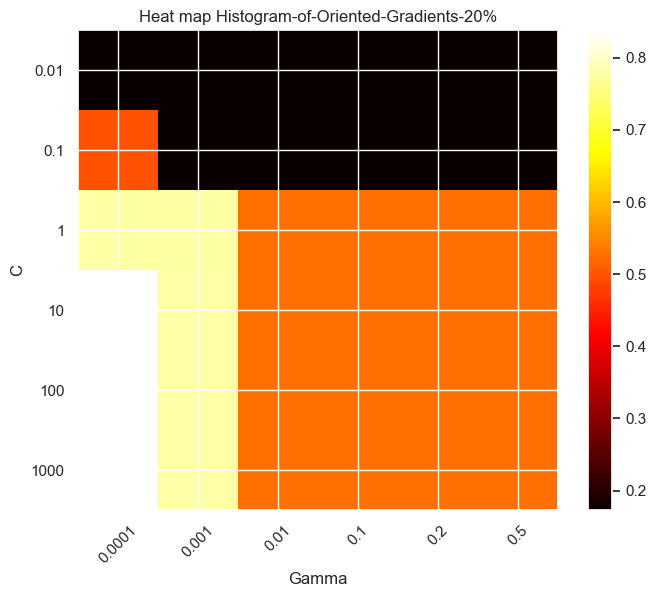

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.173 (+/-0.001) para {'C': 0.01, 'gamma': 0.0001, 'kernel': 'rbf'}
0.173 (+/-0.001) para {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
0.173 (+/-0.001) para {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.173 (+/-0.001) para {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.173 (+/-0.001) para {'C': 0.01, 'gamma': 0.2, 'kernel': 'rbf'}
0.173 (+/-0.001) para {'C': 0.01, 'gamma': 0.5, 'kernel': 'rbf'}
0.496 (+/-0.006) para {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.173 (+/-0.001) para {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.173 (+/-0.001) para {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.173 (+/-0.001) para {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.173 (+/-0.001) para {'C': 0.1, 'gamma': 0.2, 'kernel': 'rbf'}
0.173 (+/-0.001) para {'C': 0.1, 'gamma': 0.5, 'kernel': 'rbf'}
0.778 (+/-0.010) para {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.776 (+/-0.004) para {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.526 (+/-0.004) para {'C': 1, 'gamma': 0

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       101
           1       0.96      0.95      0.95       110
           2       0.93      0.97      0.95       119
           3       0.95      0.91      0.93       129
           4       0.97      0.89      0.93       135
           5       0.92      1.00      0.96       135

    accuracy                           0.95       729
   macro avg       0.95      0.95      0.95       729
weighted avg       0.95      0.95      0.95       729



c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


TAG
0    473
1    490
2    497
3    503
4    467
5    483
Name: TAG, dtype: int64
TAG
0    101
1    110
2    119
3    129
4    135
5    135
Name: TAG, dtype: int64 Counter({'5': 146, '4': 124, '2': 124, '3': 124, '1': 108, '0': 103})


c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Accuracy: 0.9890170236133993


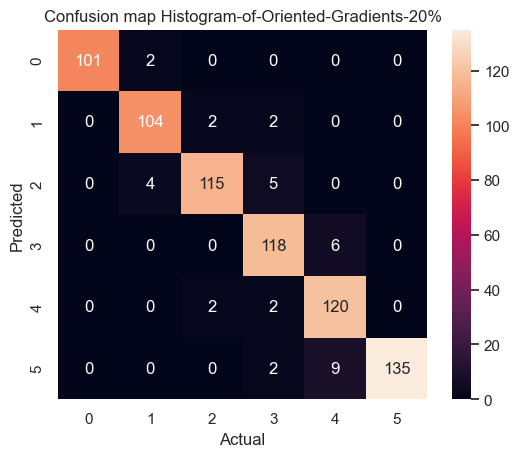

In [35]:
#As the first method of classification we use Support Vector Machine 


base = "./"

def SVM_PIPE(txt,test_percentage):
    pathsvm = base + "Feature-Extraction/SVM_PIPE/"
    
    if not os.path.exists(pathsvm):
        os.makedirs(pathsvm)
        
    data = pd.read_csv(base + '/Feature-Extraction/'+txt+'.txt',sep=',',header=None)
    
    # we shuffle it for better performance 
    # data=shuffle(data, random_state=42)
    
    s=data.shape
    col=[]
    #data.columns = ["a", "b", "c", "etc."]
     
    for x in range(0, s[1]):
        if x==0:
            col.append("NAME")
        elif x ==s[1]-1:
            col.append("TAG")
        else:
            col.append("VALOR-"+str(x))
    
    #se asigna el vector con los nombres de las columnas creado previamente y se las asignamos a la tabla
    data.columns = col
    
    ##print(data.groupby(['TAG'])['TAG'].count())
    vals_to_replace = { '0':'0', '1':'1', '2':'2', '3':'3', '4':'4', '5':'5',
                         0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5'}
    
    data['TAG'] = data['TAG'].map(vals_to_replace)
    
    #print(data.tail())
    
    no_col=['NAME','TAG']
    #obtener todas las columnas
    allValuesName = [x for x in col if x not in no_col]
    #se obtienen solo los coefficientes
    value=data[allValuesName]
    
    tags=data[col[-1]] #columna de tags
    
    data['gender'] = data['NAME'].map(lambda x: 'woman' in x.lower())
    
    # i added a stratify to the train_test_split to make sure that the train and test sets have the same proportion of class labels as the input data
    # its based on gender
    X_train, X_test, Y_train, Y_test = train_test_split(value,tags,test_size=test_percentage,stratify=data['gender'], random_state=42)
    
    
    
    C_range=[0.01, 0.1, 1, 10, 100, 1000]
    gamma_range=[1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5]
    parameters= [
        {
            'kernel': ['rbf'],
            'gamma': [1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5],
            'C': [0.01, 0.1, 1, 10, 100, 1000]
        },
    ]
    # 
    sv =GridSearchCV(svm.SVC(decision_function_shape='ovr'), param_grid=parameters,cv=2)
    pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(0.97)),('svm', sv)])
    pipe.fit(X_train.values,Y_train)
    clf = pipe['svm']
    # clf.fit(X_train.values,Y_train)
    clf.best_params_ 
    scores = clf.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))
    print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))
    
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
    plt.xlabel('Gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
    plt.yticks(np.arange(len(C_range)), C_range)
    fig=plt.title('Heat map '+txt+'-'+str(int(test_percentage*100))+'%')
    fig.get_figure().savefig(base + r'Feature-Extraction/SVM_PIPE/Heatmap-'+txt+'-'+str(int(test_percentage*100))+'%.jpg')
    plt.show()
    print(clf.best_params_)#mejor parametro
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    params = clf.cv_results_['params']
    for m, s, p in zip(means, stds, params):
        print("%0.3f (+/-%0.3f) para %r"%(m, 2*s, p))
    
    y_pred = pipe.predict(X_test)
    
    target_names=["0","1","2","3","4","5"]
    
    table=classification_report(Y_test,y_pred, target_names=target_names)
    table=str(table)
    print(table)
    file = open(base +r"Feature-Extraction/SVM_PIPE/Reports.txt", "a+")
    file.write(txt+'-'+str(int(test_percentage*100))+'%\n\n')
    file.write(table+'\n')
    file.write("Accuracy: "+str(pipe.score(value,tags)))
    mat=confusion_matrix(Y_test, y_pred)
    
    Matrizconf=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
               xticklabels=target_names, yticklabels= target_names )
    
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    mat=plt.title('Confusion map '+txt+'-'+str(int(test_percentage*100))+'%')
    
    Matrizconf.get_figure().savefig(base + r'Feature-Extraction/SVM_PIPE/Confusionmap-'+txt+'-'+str(int(test_percentage*100))+'%.png')
    print(Y_train.groupby(Y_train).count())#datos de entrenamiento
    print(Y_test.groupby(Y_test).count(),collections.Counter(y_pred))#datos de testeo
    
    joblib.dump(pipe,base +r'Feature-Extraction/SVM_PIPE/modelo_entrenado-'+txt+'-'+str(int(test_percentage*100))+'%.pkl')
    
    # se llama el modelo
    #clf=joblib.load('modelo_entrenado.pkl')
    # se toma todo el dataset
    print("Accuracy: "+str(pipe.score(value,tags)))
    file.close()
# porcentaje_test=[0.30,0.25,0.20]
# SVM_PIPE("Elliptic-Fourier",0.2)
SVM_PIPE("Histogram-of-Oriented-Gradients" ,0.2)
# SVM("HOG_EF" ,0.2)
# SVM("Cof" ,0.2)
# SVM("VHIST" ,0.3)



In [ ]:
if __name__ == "__main__":
    #Preprocessing
    # ImageSegmentation()
    #Feature Extraction
    # EllipticFourier()
    # HOG()
    # HU()
    # GM()
    # CoF()
    porcentaje_test=[0.30,0.25,0.20]
    #Classification
    for j in tqdm(range(len(porcentaje_test))):
        #Support Vector Machine
        # SVM("Elliptic-Fourier",porcentaje_test[j])
        # SVM("Histogram-of-Oriented-Gradients-PCA",porcentaje_test[j])
        # SVM("Hu-Moments-Nmz",porcentaje_test[j])
        # SVM("Geometric",porcentaje_test[j])
        SVM("CoF",porcentaje_test[j])
        # SVM("HOG_EF",porcentaje_test[j])
        #K-Nearest Neighbors
        # KNN("Elliptic-Fourier",porcentaje_test[j])
        # KNN("Histogram-of-Oriented-Gradients-PCA",porcentaje_test[j])
        # KNN("Hu-Moments-Nmz",porcentaje_test[j])
        # KNN("Geometric",porcentaje_test[j])
        KNN("CoF",porcentaje_test[j])
        # KNN("HOG_EF",porcentaje_test[j])
        #Neural Network
        # NN("Elliptic-Fourier",porcentaje_test[j])
        # NN("Histogram-of-Oriented-Gradients-PCA",porcentaje_test[j])
        # NN("Hu-Moments-Nmz",porcentaje_test[j])
        # NN("Geometric",porcentaje_test[j])
        NN("CoF",porcentaje_test[j])
        # NN("HOG_EF",porcentaje_test[j])

In [ ]:
# !rm -rf /content/kaggle/Feature-Extraction\KNN

## Conclusion
1. With this method for the recognition of Colombian sign language can be tried with new signs extending the dataset, also is open research because it can be tested with new methods of preprocessing, extraction of characteristics, classification being able to get to raise even more the percentages of prediction.

2. According to the methods used for the extraction of characteristics, based on table 2, the characteristics of the gradient-oriented histograms (HOG) are the ones that obtained the highest percentage.

3. When performing the main component analysis process, it is concluded that this process will reduce the percentage of the model's performance measure slightly.

4. The geometric characteristics did not give a good result because the images contain similar characteristics such as the area or contour, this results in the model being able to predict the signs in a bad way.